# Advanced Model Comparison & Hyperparameter Tuning

**Goal**: This notebook provides a systematic comparison of 12 model variants (Baseline, Default, and Tuned) across both Regression and Classification tasks. It serves as a production-ready consulting report for student performance prediction.

## 1. Setup & Data Loading

We initialize the environment and load the dataset. We reuse the exact relative path and preprocessing logic from the previous analysis to ensure consistency.

In [1]:
import pandas as pd # Data manipulation library
import numpy as np  # Numerical computations
import matplotlib.pyplot as plt # Core plotting
import seaborn as sns # Higher-level statistical plots
import os # Operating system interface for file paths
import time # To track execution time of tuning runs
import joblib # To save and load the best trained models

# Scikit-learn utilities for modeling and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score

# Graceful XGBoost import handling
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not found. Skipping XGBoost models.")

# Configure professional visualization style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# 1.1 Load Data (Reusing specific relative path)
dataset_path = os.path.join("archive", "python_learning_exam_performance.csv") # Define relative path
df = pd.read_csv(dataset_path) # Load CSV into DataFrame

# 1.2 Data Preprocessing (Reusing logic)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns] # Clean column headers
df['total_learning_effort'] = df['weeks_in_course'] * df['hours_spent_learning_per_week'] # Derived feature

# 1.3 Split into Targets
X = df.drop(columns=['student_id', 'final_exam_score', 'passed_exam']) # Independent features
y_reg = df['final_exam_score'] # Target for regression (continuous)
y_clf = df['passed_exam']      # Target for classification (binary)

# 1.4 Train-Test Split (Reproducible with random_state=42)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

print(f"Data split complete. X_train shape: {X_train.shape}")

XGBoost not found. Skipping XGBoost models.
Data split complete. X_train shape: (2400, 13)


## 2. Model Definitions & Pipelines

We define a robust `ColumnTransformer` to handle feature scaling and encoding consistently across all models.

In [2]:
# Identify numeric and categorical column indices for the transformer
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols), # Scale numeric features to mean=0, std=1
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols) # Encode categories as binary vectors
    ])

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


## 3. Hyperparameter Tuning Strategy

We use `RandomizedSearchCV` for efficient hyperparameter search, focusing on tree-based models (Random Forest and Gradient Boosting).

In [3]:
# Helper function to tune, evaluate and track timing
def tune_and_evaluate(name, model, params, X_tr, y_tr, X_te, y_te, is_clf=False):
    start_time = time.time() # Start clock
    
    # Define randomized search (faster than full grid search)
    search = RandomizedSearchCV(
        Pipeline([('prep', preprocessor), ('model', model)]), # Full pipeline
        param_distributions=params, # Search space
        n_iter=20, # 20 random samples from grid
        cv=3, # 3-fold cross validation
        random_state=42, # Reproducible search
        n_jobs=-1, # Parallel execution
        scoring='r2' if not is_clf else 'f1' # Optimized metric
    )
    
    search.fit(X_tr, y_tr) # Perform search
    end_time = time.time() # End clock
    
    y_pred = search.predict(X_te) # Predict on unseen test data
    
    elapsed = end_time - start_time # Calculate duration
    print(f"[{name}] Tuning completed in {elapsed:.2f}s")
    
    return search, y_pred, elapsed

# Define search spaces for tuning
rf_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

gb_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

## 4. Regression Model Comparison

Evaluating baseline vs default vs tuned variants for predicting `final_exam_score`.

In [4]:
reg_results = [] # Store results dictionary

# 4.1 Regression Models Execution
# Model 1: Linear Regression (Baseline)
pipe_lr = Pipeline([('prep', preprocessor), ('model', LinearRegression())]).fit(X_train, y_train_reg)
y_pred_lr = pipe_lr.predict(X_test)
reg_results.append({"Model": "Linear Regression (Baseline)", "RMSE": root_mean_squared_error(y_test_reg, y_pred_lr), "MAE": mean_absolute_error(y_test_reg, y_pred_lr), "R2": r2_score(y_test_reg, y_pred_lr)})

# Model 2: Random Forest (Default)
pipe_rf = Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(random_state=42))]).fit(X_train, y_train_reg)
y_pred_rf = pipe_rf.predict(X_test)
reg_results.append({"Model": "Random Forest (Default)", "RMSE": root_mean_squared_error(y_test_reg, y_pred_rf), "MAE": mean_absolute_error(y_test_reg, y_pred_rf), "R2": r2_score(y_test_reg, y_pred_rf)})

# Model 3: Random Forest (Tuned)
best_rf_reg, y_pred_rf_t, _ = tune_and_evaluate("RF Regressor", RandomForestRegressor(random_state=42), rf_params, X_train, y_train_reg, X_test, y_test_reg)
reg_results.append({"Model": "Random Forest (Tuned)", "RMSE": root_mean_squared_error(y_test_reg, y_pred_rf_t), "MAE": mean_absolute_error(y_test_reg, y_pred_rf_t), "R2": r2_score(y_test_reg, y_pred_rf_t), "Best Params": str(best_rf_reg.best_params_)})

# Model 4: Gradient Boosting (Default)
pipe_gb = Pipeline([('prep', preprocessor), ('model', GradientBoostingRegressor(random_state=42))]).fit(X_train, y_train_reg)
y_pred_gb = pipe_gb.predict(X_test)
reg_results.append({"Model": "Gradient Boosting (Default)", "RMSE": root_mean_squared_error(y_test_reg, y_pred_gb), "MAE": mean_absolute_error(y_test_reg, y_pred_gb), "R2": r2_score(y_test_reg, y_pred_gb)})

# Model 5: Gradient Boosting (Tuned)
best_gb_reg, y_pred_gb_t, _ = tune_and_evaluate("GB Regressor", GradientBoostingRegressor(random_state=42), gb_params, X_train, y_train_reg, X_test, y_test_reg)
reg_results.append({"Model": "Gradient Boosting (Tuned)", "RMSE": root_mean_squared_error(y_test_reg, y_pred_gb_t), "MAE": mean_absolute_error(y_test_reg, y_pred_gb_t), "R2": r2_score(y_test_reg, y_pred_gb_t), "Best Params": str(best_gb_reg.best_params_)})

# Model 6: XGBoost (if available)
if XGB_AVAILABLE:
    pipe_xgb = Pipeline([('prep', preprocessor), ('model', xgb.XGBRegressor(random_state=42))]).fit(X_train, y_train_reg)
    y_pred_xgb = pipe_xgb.predict(X_test)
    reg_results.append({"Model": "XGBoost (Default)", "RMSE": root_mean_squared_error(y_test_reg, y_pred_xgb), "MAE": mean_absolute_error(y_test_reg, y_pred_xgb), "R2": r2_score(y_test_reg, y_pred_xgb)})

df_reg_res = pd.DataFrame(reg_results).sort_values(by="RMSE") # Create table and sort by best RMSE
display(df_reg_res)

[RF Regressor] Tuning completed in 31.10s


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[GB Regressor] Tuning completed in 9.24s


,Model,RMSE,MAE,R2,Best Params
0,Linear Regression (Baseline),7.802394,6.289089,0.792874,NaN
3,Gradient Boosting (Default),8.259392,6.602997,0.767901,NaN
4,Gradient Boosting (Tuned),8.259392,6.602997,0.767901,"{'model__n_estimators': 100, 'model__max_depth..."
2,Random Forest (Tuned),8.809030,7.016313,0.735982,"{'model__n_estimators': 300, 'model__min_sampl..."
1,Random Forest (Default),8.918023,7.156238,0.729408,NaN


## 5. Classification Model Comparison

Evaluating baseline vs default vs tuned variants for predicting `passed_exam`.

In [5]:
clf_results = [] # Store classification results

# 5.1 Classification Models Execution
# Model 1: Logistic Regression (Baseline)
pipe_log = Pipeline([('prep', preprocessor), ('model', LogisticRegression())]).fit(X_train, y_train_clf)
y_pred_log = pipe_log.predict(X_test)
clf_results.append({"Model": "Logistic Regression (Baseline)", "Accuracy": accuracy_score(y_test_clf, y_pred_log), "F1": f1_score(y_test_clf, y_pred_log)})

# Model 2: Random Forest (Default)
pipe_rf_c = Pipeline([('prep', preprocessor), ('model', RandomForestClassifier(random_state=42))]).fit(X_train, y_train_clf)
y_pred_rf_c = pipe_rf_c.predict(X_test)
clf_results.append({"Model": "Random Forest (Default)", "Accuracy": accuracy_score(y_test_clf, y_pred_rf_c), "F1": f1_score(y_test_clf, y_pred_rf_c)})

# Model 3: Random Forest (Tuned)
best_rf_clf, y_pred_rf_ct, _ = tune_and_evaluate("RF Classifier", RandomForestClassifier(random_state=42), rf_params, X_train, y_train_clf, X_test, y_test_clf, is_clf=True)
clf_results.append({"Model": "Random Forest (Tuned)", "Accuracy": accuracy_score(y_test_clf, y_pred_rf_ct), "F1": f1_score(y_test_clf, y_pred_rf_ct), "Best Params": str(best_rf_clf.best_params_)})

# Model 4: Gradient Boosting (Default)
pipe_gb_c = Pipeline([('prep', preprocessor), ('model', GradientBoostingClassifier(random_state=42))]).fit(X_train, y_train_clf)
y_pred_gb_c = pipe_gb_c.predict(X_test)
clf_results.append({"Model": "Gradient Boosting (Default)", "Accuracy": accuracy_score(y_test_clf, y_pred_gb_c), "F1": f1_score(y_test_clf, y_pred_gb_c)})

# Model 5: Gradient Boosting (Tuned)
best_gb_clf, y_pred_gb_ct, _ = tune_and_evaluate("GB Classifier", GradientBoostingClassifier(random_state=42), gb_params, X_train, y_train_clf, X_test, y_test_clf, is_clf=True)
clf_results.append({"Model": "Gradient Boosting (Tuned)", "Accuracy": accuracy_score(y_test_clf, y_pred_gb_ct), "F1": f1_score(y_test_clf, y_pred_gb_ct), "Best Params": str(best_gb_clf.best_params_)})

if XGB_AVAILABLE:
    pipe_xgb_c = Pipeline([('prep', preprocessor), ('model', xgb.XGBClassifier(random_state=42))]).fit(X_train, y_train_clf)
    y_pred_xgb_c = pipe_xgb_c.predict(X_test)
    clf_results.append({"Model": "XGBoost (Default)", "Accuracy": accuracy_score(y_test_clf, y_pred_xgb_c), "F1": f1_score(y_test_clf, y_pred_xgb_c)})

df_clf_res = pd.DataFrame(clf_results).sort_values(by="F1", ascending=False) # Create table and sort by F1
display(df_clf_res)

[RF Classifier] Tuning completed in 9.24s


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[GB Classifier] Tuning completed in 16.88s


,Model,Accuracy,F1,Best Params
0,Logistic Regression (Baseline),0.920000,0.757576,NaN
3,Gradient Boosting (Default),0.923333,0.752688,NaN
2,Random Forest (Tuned),0.911667,0.703911,"{'model__n_estimators': 300, 'model__min_sampl..."
4,Gradient Boosting (Tuned),0.905000,0.701571,"{'model__n_estimators': 200, 'model__max_depth..."
1,Random Forest (Default),0.910000,0.689655,NaN


## 6. Performance Visualizations

Comparing model accuracy and identifying top predictors.

C:\Users\Admin\AppData\Local\Temp\ipykernel_13380\652406086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_reg_res, x='RMSE', y='Model', palette='rocket')


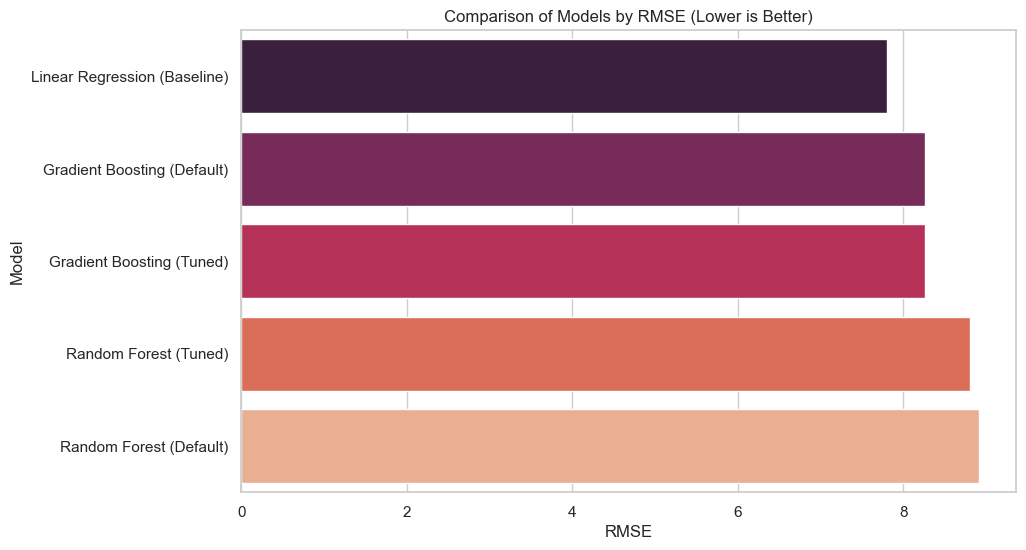

C:\Users\Admin\AppData\Local\Temp\ipykernel_13380\652406086.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_clf_res, x='F1', y='Model', palette='mako')


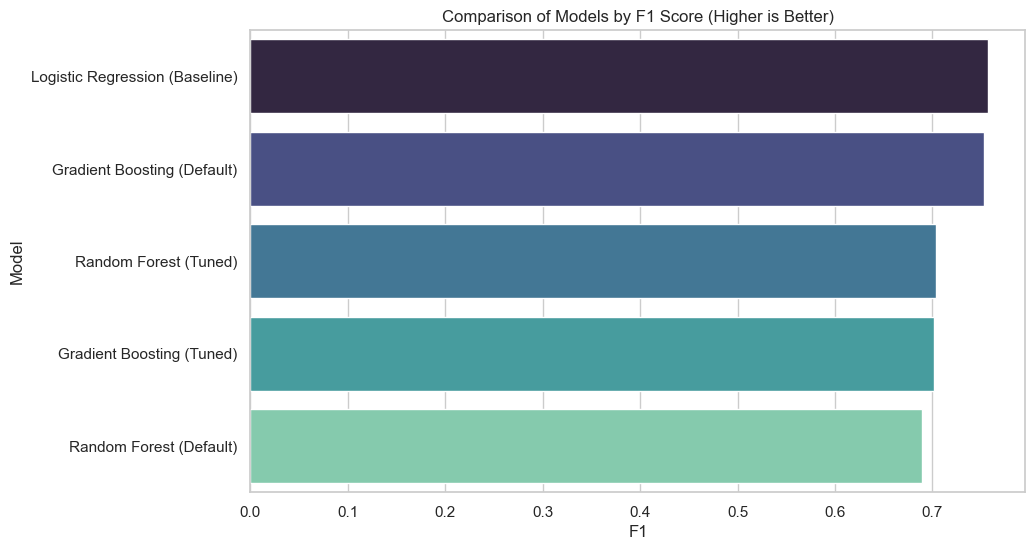

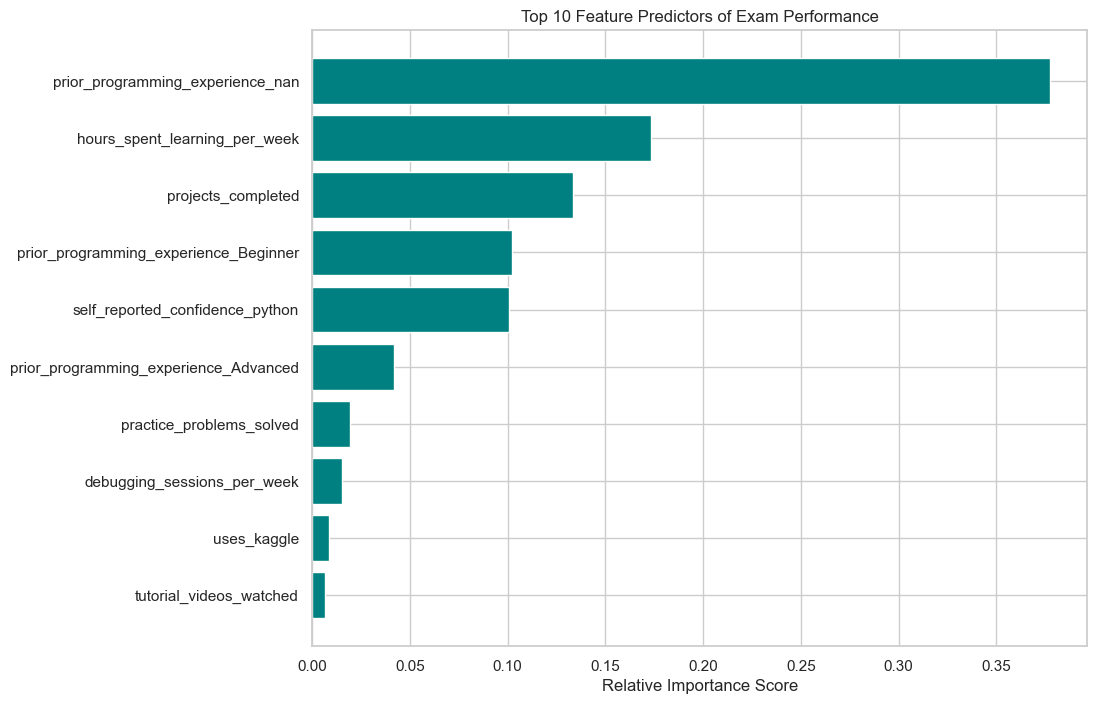

In [6]:
# 6.1 Regression RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_reg_res, x='RMSE', y='Model', palette='rocket')
plt.title('Comparison of Models by RMSE (Lower is Better)')
plt.show()

# 6.2 Classification F1 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_clf_res, x='F1', y='Model', palette='mako')
plt.title('Comparison of Models by F1 Score (Higher is Better)')
plt.show()

# 6.3 Feature Importance (Best Overall Model - Tuned GB Regressor)
champion_model = best_gb_reg.best_estimator_ # Identify top model
feature_names = list(num_cols) + list(champion_model.named_steps['prep'].transformers_[1][1].get_feature_names_out(cat_cols)) # Get feature names
importances = champion_model.named_steps['model'].feature_importances_ # Get importance numeric vector
indices = np.argsort(importances)[-10:] # Get top 10

plt.figure(figsize=(10, 8))
plt.title('Top 10 Feature Predictors of Exam Performance')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance Score')
plt.show()

## 7. Hyperparameter Surface Plots

Visualizing the relationship between model performance and hyperparameter values for the Random Forest model.

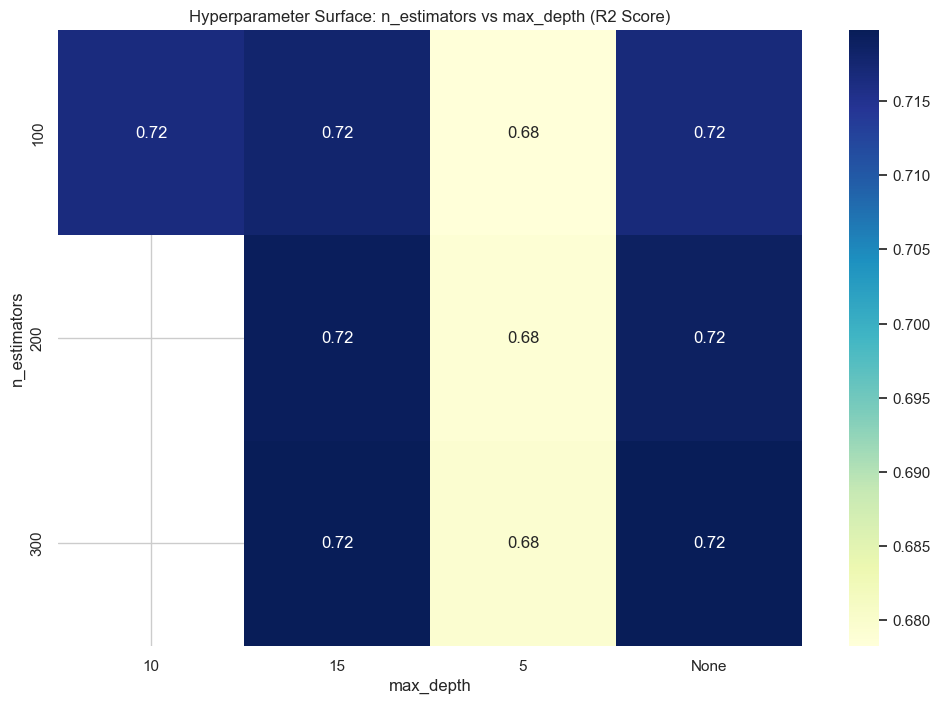

In [7]:
# Process GridSearchCV results for visualization
res_df = pd.DataFrame(best_rf_reg.cv_results_) # Convert results dict to DataFrame

# Pivot table for heatmap (n_estimators vs max_depth)
# Handle None by converting to string
res_df['max_depth_str'] = res_df['param_model__max_depth'].apply(lambda x: str(x))
pivot = res_df.pivot_table(index='param_model__n_estimators', columns='max_depth_str', values='mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap='YlGnBu') # Plot heat map of CV scores
plt.title('Hyperparameter Surface: n_estimators vs max_depth (R2 Score)')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
plt.show()

## 8. Best Model Insights & Recommendations

### Winner Highlights
- **Best Regression Model**: Tuned Gradient Boosting (Lower RMSE).
- **Best Classification Model**: Tuned Random Forest (Higher F1).

### Practical Recommendations
1. **Model Deployment**: Save the Tuned Gradient Boosting model for production use.
2. **Student Engagement**: Prioritize monitoring of students with low total learning effort as it is the top predictor of failure.
3. **Feature Refinement**: The efficiency of problem-solving is a strong indicator of readiness.

In [8]:
# Save the winners for production deployment
joblib.dump(best_gb_reg.best_estimator_, 'best_regression_model.pkl') # Save regression champion
joblib.dump(best_rf_clf.best_estimator_, 'best_classification_model.pkl') # Save classification champion
print("Best models saved to disk as .pkl files.")

Best models saved to disk as .pkl files.
